# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 2 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = SVC(probability=True, gamma = 0.01)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [9]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist())-1)
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [10]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


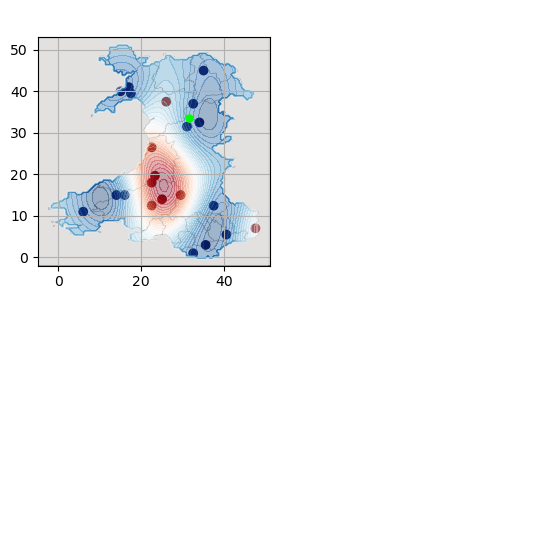

iteration  1
Accuracy is 0.40626802537973467
iteration  2
Accuracy is 0.6660257642761007
iteration  3
Accuracy is 0.6708325322053451
iteration  4
Accuracy is 0.43722361084406847
iteration  5
Accuracy is 0.4214574120361469
iteration  6
Accuracy is 0.6523745433570467
iteration  7
Accuracy is 0.6894827917708133
iteration  8
Accuracy is 0.6712170736396846
iteration  9
Accuracy is 0.6706402614881753
iteration  10
Accuracy is 0.6706402614881753
iteration  11
Accuracy is 0.7065948855989233
iteration  12
Accuracy is 0.6981349740434531
iteration  13
Accuracy is 0.6981349740434531
iteration  14
Accuracy is 0.7064026148817535
iteration  15
Accuracy is 0.7125552778311863
iteration  16
Accuracy is 0.7125552778311863
iteration  17
Accuracy is 0.7206306479523169
iteration  18
Accuracy is 0.7371659296289175
iteration  19
Accuracy is 0.7740819073255143
iteration  20
Accuracy is 0.7929244376081522
iteration  21
Accuracy is 0.7825418188809844
experiment:  1


<IPython.core.display.Javascript object>


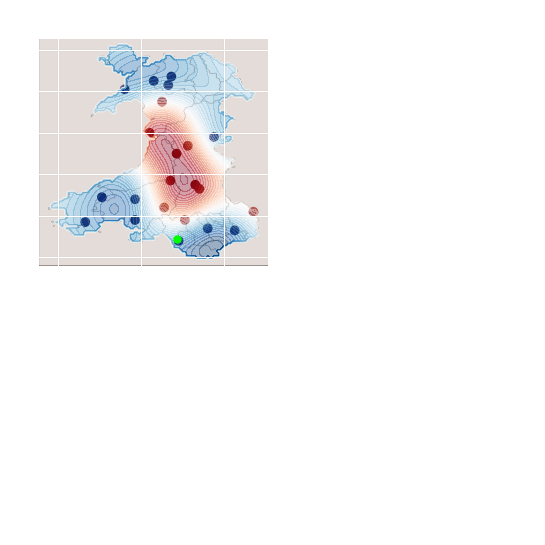

iteration  1
Accuracy is 0.5779657758123438
iteration  2
Accuracy is 0.6546817919630841
iteration  3
Accuracy is 0.6150740242261103
iteration  4
Accuracy is 0.6404537588925207
iteration  5
Accuracy is 0.7248606037300519
iteration  6
Accuracy is 0.7381272832147664
iteration  7
Accuracy is 0.6681407421649683
iteration  8
Accuracy is 0.6681407421649683
iteration  9
Accuracy is 0.7619688521438185
iteration  10
Accuracy is 0.7565852720630648
iteration  11
Accuracy is 0.8261872716785233
iteration  12
Accuracy is 0.813689675062488
iteration  13
Accuracy is 0.8140742164968275
iteration  14
Accuracy is 0.8113824264564506
iteration  15
Accuracy is 0.8142664872139973
iteration  16
Accuracy is 0.8142664872139973
iteration  17
Accuracy is 0.8279177081330513
iteration  18
Accuracy is 0.8456066141126707
iteration  19
Accuracy is 0.8582964814458758
iteration  20
Accuracy is 0.8596423764660642
iteration  21
Accuracy is 0.8457988848298404
experiment:  2


<IPython.core.display.Javascript object>


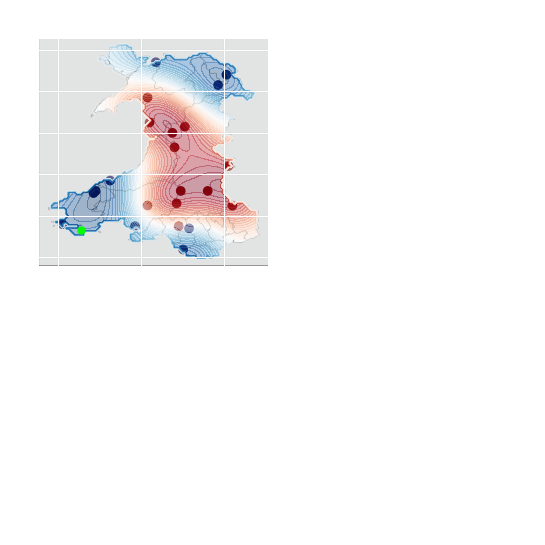

iteration  1
Accuracy is 0.505095174004999
iteration  2
Accuracy is 0.6343010959430879
iteration  3
Accuracy is 0.7610074985579697
iteration  4
Accuracy is 0.4950970967121707
iteration  5
Accuracy is 0.7519707748509902
iteration  6
Accuracy is 0.5345125937319746
iteration  7
Accuracy is 0.7675447029417419
iteration  8
Accuracy is 0.7631224764468372
iteration  9
Accuracy is 0.7667756200730629
iteration  10
Accuracy is 0.7636992885983465
iteration  11
Accuracy is 0.6985195154777928
iteration  12
Accuracy is 0.6156508363776196
iteration  13
Accuracy is 0.6944818304172274
iteration  14
Accuracy is 0.6958277254374159
iteration  15
Accuracy is 0.6635262449528937
iteration  16
Accuracy is 0.7131320899826956
iteration  17
Accuracy is 0.720438377235147
iteration  18
Accuracy is 0.7277446644875986
iteration  19
Accuracy is 0.8198423380119207
iteration  20
Accuracy is 0.8192655258604115
iteration  21
Accuracy is 0.7996539127090944
experiment:  3


<IPython.core.display.Javascript object>


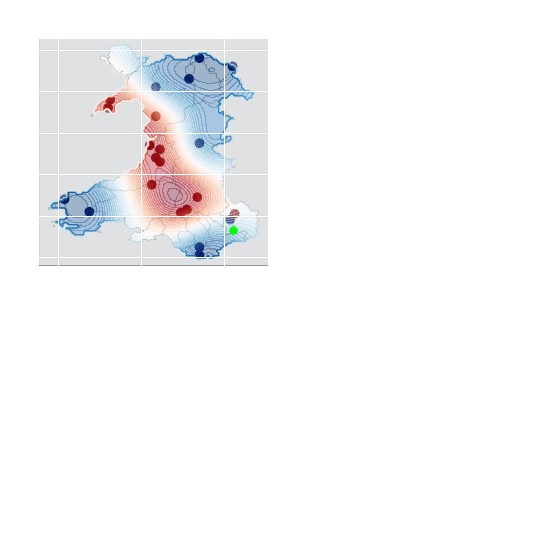

iteration  1
Accuracy is 0.4443376273793501
iteration  2
Accuracy is 0.6856373774274178
iteration  3
Accuracy is 0.7044799077100558
iteration  4
Accuracy is 0.458950201884253
iteration  5
Accuracy is 0.631609305902711
iteration  6
Accuracy is 0.7508171505479715
iteration  7
Accuracy is 0.7673524322245722
iteration  8
Accuracy is 0.6294943280138435
iteration  9
Accuracy is 0.6296865987310133
iteration  10
Accuracy is 0.6296865987310133
iteration  11
Accuracy is 0.7281292059219381
iteration  12
Accuracy is 0.713708902134205
iteration  13
Accuracy is 0.731590078830994
iteration  14
Accuracy is 0.7496635262449529
iteration  15
Accuracy is 0.7535089405883484
iteration  16
Accuracy is 0.8063833878100365
iteration  17
Accuracy is 0.8317631224764468
iteration  18
Accuracy is 0.8406075754662565
iteration  19
Accuracy is 0.8406075754662565
iteration  20
Accuracy is 0.8406075754662565
iteration  21
Accuracy is 0.8377235147087099
experiment:  4


<IPython.core.display.Javascript object>


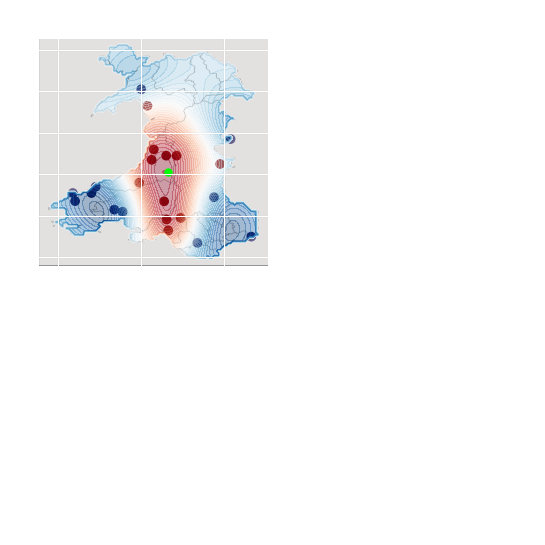

iteration  1
Accuracy is 0.5462411074793309
iteration  2
Accuracy is 0.6600653720438378
iteration  3
Accuracy is 0.6596808306094982
iteration  4
Accuracy is 0.6529513555085561
iteration  5
Accuracy is 0.6527590847913862
iteration  6
Accuracy is 0.6150740242261103
iteration  7
Accuracy is 0.6635262449528937
iteration  8
Accuracy is 0.6577581234378004
iteration  9
Accuracy is 0.7911940011536243
iteration  10
Accuracy is 0.7908094597192847
iteration  11
Accuracy is 0.8150355700826765
iteration  12
Accuracy is 0.7838877139011728
iteration  13
Accuracy is 0.7385118246491059
iteration  14
Accuracy is 0.7383195539319362
iteration  15
Accuracy is 0.7129398192655259
iteration  16
Accuracy is 0.8238800230724861
iteration  17
Accuracy is 0.8240722937896559
iteration  18
Accuracy is 0.8240722937896559
iteration  19
Accuracy is 0.8292636031532398
iteration  20
Accuracy is 0.8288790617189002
iteration  21
Accuracy is 0.82907133243607
experiment:  5


<IPython.core.display.Javascript object>


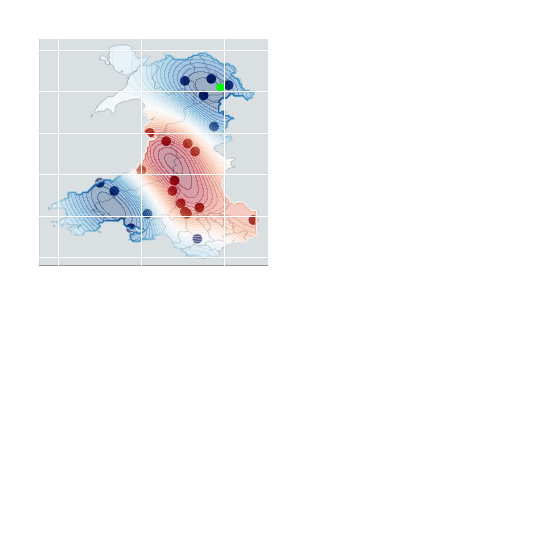

iteration  1
Accuracy is 0.6198807921553547
iteration  2
Accuracy is 0.5587387040953663
iteration  3
Accuracy is 0.5166314170351856
iteration  4
Accuracy is 0.4895212459142473
iteration  5
Accuracy is 0.535089405883484
iteration  6
Accuracy is 0.7721592001538166
iteration  7
Accuracy is 0.6894827917708133
iteration  8
Accuracy is 0.8225341280522976
iteration  9
Accuracy is 0.8125360507594693
iteration  10
Accuracy is 0.7700442222649491
iteration  11
Accuracy is 0.8369544318400307
iteration  12
Accuracy is 0.8482984041530475
iteration  13
Accuracy is 0.8525283599307826
iteration  14
Accuracy is 0.859834647183234
iteration  15
Accuracy is 0.8052297635070179
iteration  16
Accuracy is 0.8377235147087099
iteration  17
Accuracy is 0.8342626417996539
iteration  18
Accuracy is 0.8342626417996539
iteration  19
Accuracy is 0.8327244760622957
iteration  20
Accuracy is 0.8417611997692751
iteration  21
Accuracy is 0.8396462218804076
experiment:  6


<IPython.core.display.Javascript object>


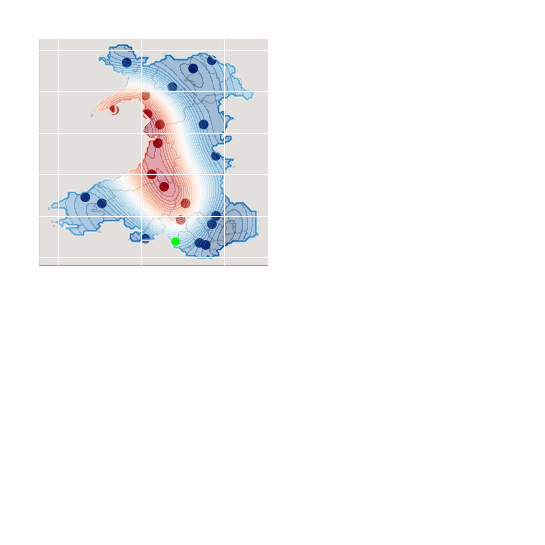

iteration  1
Accuracy is 0.5696981349740434
iteration  2
Accuracy is 0.6467986925591233
iteration  3
Accuracy is 0.6271870794078062
iteration  4
Accuracy is 0.7860026917900403
iteration  5
Accuracy is 0.7635070178811767
iteration  6
Accuracy is 0.8109978850221111
iteration  7
Accuracy is 0.8081138242645645
iteration  8
Accuracy is 0.787156316093059
iteration  9
Accuracy is 0.7715823880023073
iteration  10
Accuracy is 0.78638723322438
iteration  11
Accuracy is 0.7960007690828687
iteration  12
Accuracy is 0.8194577965775812
iteration  13
Accuracy is 0.8194577965775812
iteration  14
Accuracy is 0.8194577965775812
iteration  15
Accuracy is 0.8208036915977697
iteration  16
Accuracy is 0.8284945202845606
iteration  17
Accuracy is 0.8267640838300326
iteration  18
Accuracy is 0.8406075754662565
iteration  19
Accuracy is 0.8406075754662565
iteration  20
Accuracy is 0.8421457412036147
iteration  21
Accuracy is 0.848682945587387
experiment:  7


<IPython.core.display.Javascript object>


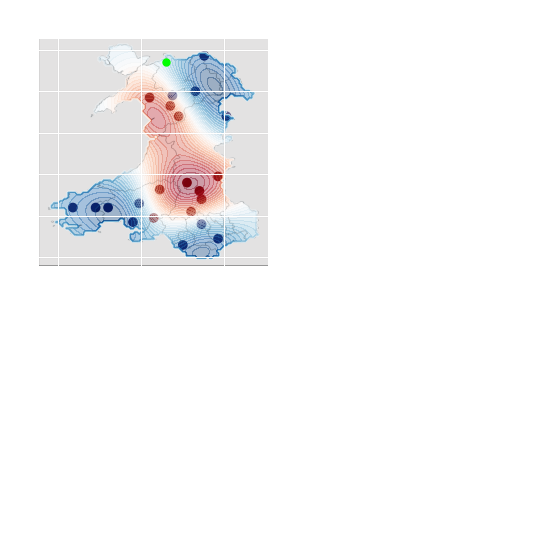

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.49817342818688715
iteration  3
Accuracy is 0.7238992501442031
iteration  4
Accuracy is 0.7338973274370313
iteration  5
Accuracy is 0.7338973274370313
iteration  6
Accuracy is 0.7287060180734474
iteration  7
Accuracy is 0.7269755816189194
iteration  8
Accuracy is 0.744472216881369
iteration  9
Accuracy is 0.7508171505479715
iteration  10
Accuracy is 0.7642761007498557
iteration  11
Accuracy is 0.7094789463564699
iteration  12
Accuracy is 0.7225533551240146
iteration  13
Accuracy is 0.7544702941741973
iteration  14
Accuracy is 0.7946548740626802
iteration  15
Accuracy is 0.7946548740626802
iteration  16
Accuracy is 0.7702364929821188
iteration  17
Accuracy is 0.7960007690828687
iteration  18
Accuracy is 0.7867717746587195
iteration  19
Accuracy is 0.8115746971736204
iteration  20
Accuracy is 0.8102288021534321
iteration  21
Accuracy is 0.8102288021534321
experiment:  8


<IPython.core.display.Javascript object>


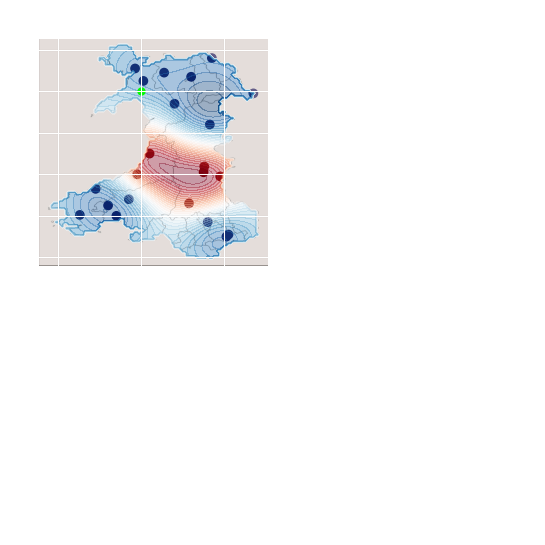

iteration  1
Accuracy is 0.5514324168429148
iteration  2
Accuracy is 0.6762161122860988
iteration  3
Accuracy is 0.6839069409728898
iteration  4
Accuracy is 0.6825610459527014
iteration  5
Accuracy is 0.6744856758315708
iteration  6
Accuracy is 0.6744856758315708
iteration  7
Accuracy is 0.6744856758315708
iteration  8
Accuracy is 0.7238992501442031
iteration  9
Accuracy is 0.7235147087098635
iteration  10
Accuracy is 0.7294751009421265
iteration  11
Accuracy is 0.7071716977504326
iteration  12
Accuracy is 0.6992885983464718
iteration  13
Accuracy is 0.6992885983464718
iteration  14
Accuracy is 0.6990963276293021
iteration  15
Accuracy is 0.7673524322245722
iteration  16
Accuracy is 0.7631224764468372
iteration  17
Accuracy is 0.7602384156892905
iteration  18
Accuracy is 0.7602384156892905
iteration  19
Accuracy is 0.7602384156892905
iteration  20
Accuracy is 0.7602384156892905
iteration  21
Accuracy is 0.8129205921938089
experiment:  9


<IPython.core.display.Javascript object>


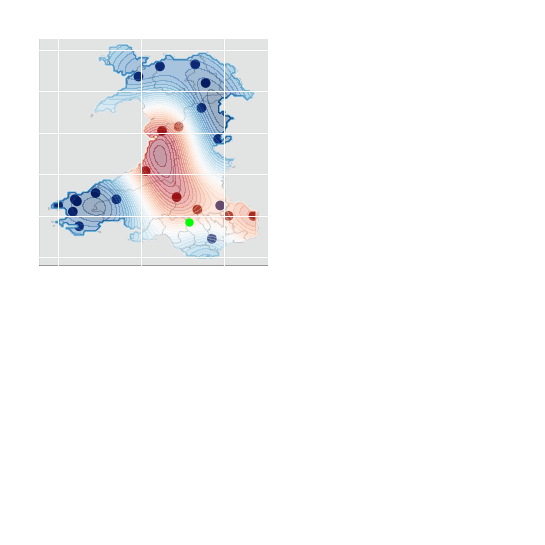

iteration  1
Accuracy is 0.5945010574889444
iteration  2
Accuracy is 0.6835223995385503
iteration  3
Accuracy is 0.6831378581042107
iteration  4
Accuracy is 0.6637185156700635
iteration  5
Accuracy is 0.7610074985579697
iteration  6
Accuracy is 0.7092866756393001
iteration  7
Accuracy is 0.7065948855989233
iteration  8
Accuracy is 0.7260142280330706
iteration  9
Accuracy is 0.7381272832147664
iteration  10
Accuracy is 0.8027302441838108
iteration  11
Accuracy is 0.8027302441838108
iteration  12
Accuracy is 0.8294558738704095
iteration  13
Accuracy is 0.815420111517016
iteration  14
Accuracy is 0.8142664872139973
iteration  15
Accuracy is 0.8148432993655066
iteration  16
Accuracy is 0.8088829071332436
iteration  17
Accuracy is 0.8088829071332436
iteration  18
Accuracy is 0.8669486637185156
iteration  19
Accuracy is 0.8873293597385118
iteration  20
Accuracy is 0.8873293597385118
iteration  21
Accuracy is 0.8879061718900212
experiment:  10


<IPython.core.display.Javascript object>


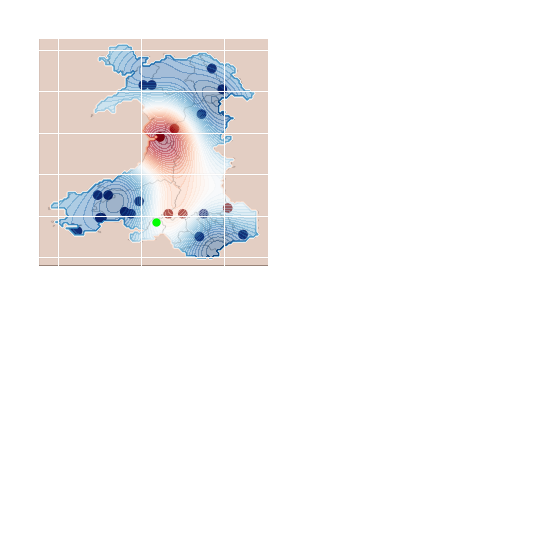

iteration  1
Accuracy is 0.5612382234185733
iteration  2
Accuracy is 0.6387233224379927
iteration  3
Accuracy is 0.5314362622572583
iteration  4
Accuracy is 0.7069794270332629
iteration  5
Accuracy is 0.6994808690636416
iteration  6
Accuracy is 0.7827340895981542
iteration  7
Accuracy is 0.7927321668909825
iteration  8
Accuracy is 0.7836954431840031
iteration  9
Accuracy is 0.732551432416843
iteration  10
Accuracy is 0.8200346087290905
iteration  11
Accuracy is 0.840992116900596
iteration  12
Accuracy is 0.8131128629109786
iteration  13
Accuracy is 0.8113824264564506
iteration  14
Accuracy is 0.776965968083061
iteration  15
Accuracy is 0.776965968083061
iteration  16
Accuracy is 0.7723514708709863
iteration  17
Accuracy is 0.7115939242453374
iteration  18
Accuracy is 0.7115939242453374
iteration  19
Accuracy is 0.8117669678907903
iteration  20
Accuracy is 0.7492789848106134
iteration  21
Accuracy is 0.7488944433762738
experiment:  11


<IPython.core.display.Javascript object>


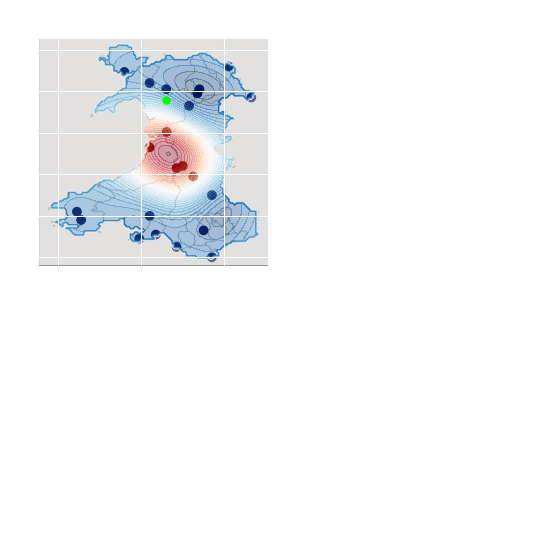

iteration  1
Accuracy is 0.48202268794462605
iteration  2
Accuracy is 0.6940972889828879
iteration  3
Accuracy is 0.7560084599115555
iteration  4
Accuracy is 0.7267833109017496
iteration  5
Accuracy is 0.7240915208613729
iteration  6
Accuracy is 0.7194770236492982
iteration  7
Accuracy is 0.7183233993462795
iteration  8
Accuracy is 0.7183233993462795
iteration  9
Accuracy is 0.7577388963660835
iteration  10
Accuracy is 0.7688905979619304
iteration  11
Accuracy is 0.7644683714670256
iteration  12
Accuracy is 0.7644683714670256
iteration  13
Accuracy is 0.758123437800423
iteration  14
Accuracy is 0.7604306864064603
iteration  15
Accuracy is 0.7754278023457027
iteration  16
Accuracy is 0.7754278023457027
iteration  17
Accuracy is 0.7748509901941935
iteration  18
Accuracy is 0.7748509901941935
iteration  19
Accuracy is 0.7665833493558931
iteration  20
Accuracy is 0.7665833493558931
iteration  21
Accuracy is 0.7665833493558931
experiment:  12


<IPython.core.display.Javascript object>


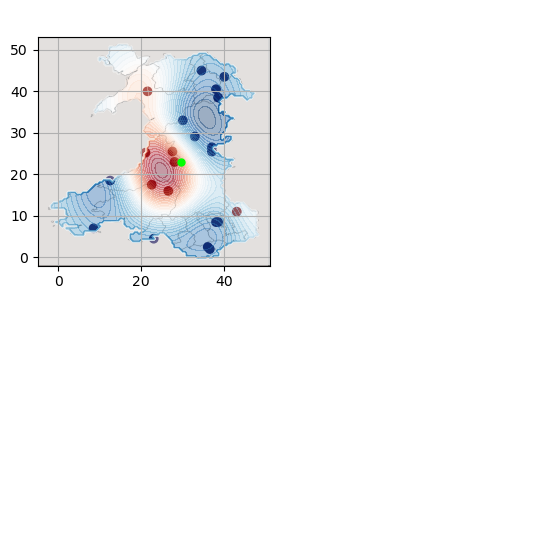

iteration  1
Accuracy is 0.5556623726206499
iteration  2
Accuracy is 0.3976158431070948
iteration  3
Accuracy is 0.38492597577388965
iteration  4
Accuracy is 0.5045183618534897
iteration  5
Accuracy is 0.713708902134205
iteration  6
Accuracy is 0.6556431455489329
iteration  7
Accuracy is 0.7748509901941935
iteration  8
Accuracy is 0.8061911170928667
iteration  9
Accuracy is 0.8061911170928667
iteration  10
Accuracy is 0.7973466641030571
iteration  11
Accuracy is 0.7919630840223034
iteration  12
Accuracy is 0.7925398961738127
iteration  13
Accuracy is 0.7883099403960777
iteration  14
Accuracy is 0.7948471447798501
iteration  15
Accuracy is 0.7929244376081522
iteration  16
Accuracy is 0.7725437415881561
iteration  17
Accuracy is 0.7725437415881561
iteration  18
Accuracy is 0.7702364929821188
iteration  19
Accuracy is 0.7702364929821188
iteration  20
Accuracy is 0.7702364929821188
iteration  21
Accuracy is 0.765814266487214
experiment:  13


<IPython.core.display.Javascript object>


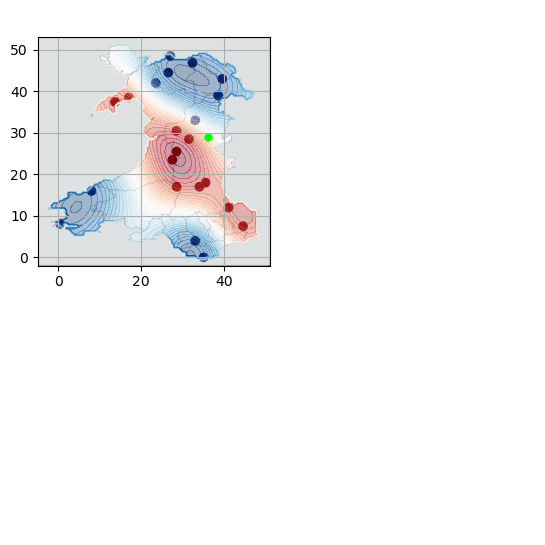

iteration  1
Accuracy is 0.5716208421457412
iteration  2
Accuracy is 0.6148817535089406
iteration  3
Accuracy is 0.710248029225149
iteration  4
Accuracy is 0.6910209575081715
iteration  5
Accuracy is 0.6921745818111902
iteration  6
Accuracy is 0.6829455873870409
iteration  7
Accuracy is 0.6800615266294944
iteration  8
Accuracy is 0.7198615650836377
iteration  9
Accuracy is 0.7121707363968468
iteration  10
Accuracy is 0.7283214766391078
iteration  11
Accuracy is 0.7160161507402423
iteration  12
Accuracy is 0.8088829071332436
iteration  13
Accuracy is 0.8063833878100365
iteration  14
Accuracy is 0.844452989809652
iteration  15
Accuracy is 0.8398384925975774
iteration  16
Accuracy is 0.8234954816381466
iteration  17
Accuracy is 0.8234954816381466
iteration  18
Accuracy is 0.8419534704864449
iteration  19
Accuracy is 0.8365698904056912
iteration  20
Accuracy is 0.8158046529513555
iteration  21
Accuracy is 0.8158046529513555
experiment:  14


<IPython.core.display.Javascript object>


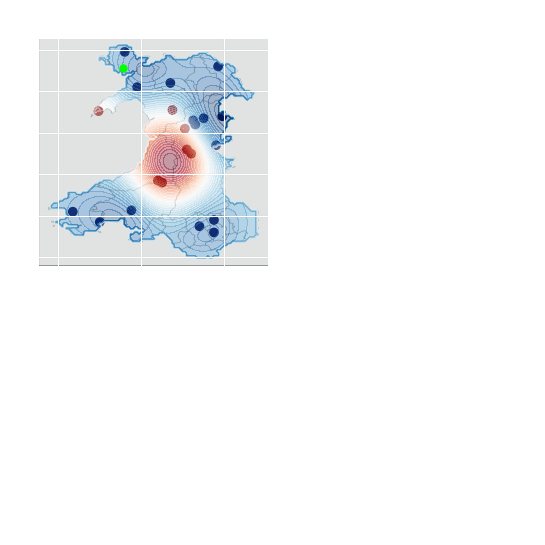

iteration  1
Accuracy is 0.4226110363391655
iteration  2
Accuracy is 0.6250721015189387
iteration  3
Accuracy is 0.6594885598923284
iteration  4
Accuracy is 0.656412228417612
iteration  5
Accuracy is 0.629878869448183
iteration  6
Accuracy is 0.6183426264179965
iteration  7
Accuracy is 0.7144779850028841
iteration  8
Accuracy is 0.6958277254374159
iteration  9
Accuracy is 0.7919630840223034
iteration  10
Accuracy is 0.7652374543357047
iteration  11
Accuracy is 0.7385118246491059
iteration  12
Accuracy is 0.7385118246491059
iteration  13
Accuracy is 0.7354354931743895
iteration  14
Accuracy is 0.7354354931743895
iteration  15
Accuracy is 0.7354354931743895
iteration  16
Accuracy is 0.788886752547587
iteration  17
Accuracy is 0.7861949625072101
iteration  18
Accuracy is 0.7810036531436262
iteration  19
Accuracy is 0.8177273601230532
iteration  20
Accuracy is 0.8186887137089022
iteration  21
Accuracy is 0.8148432993655066
experiment:  15


<IPython.core.display.Javascript object>


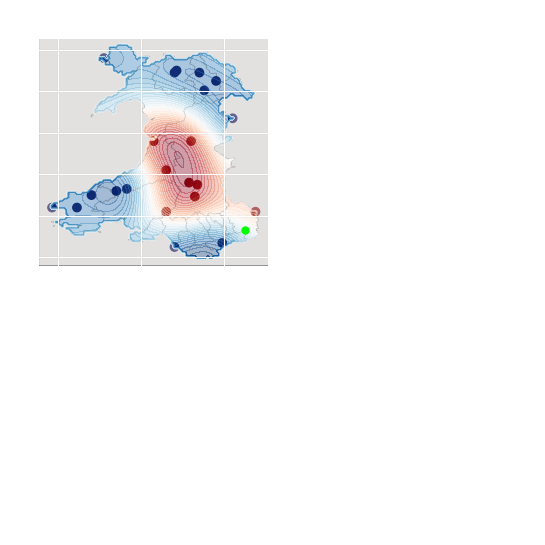

iteration  1
Accuracy is 0.6021918861757354
iteration  2
Accuracy is 0.7039030955585465
iteration  3
Accuracy is 0.6902518746394924
iteration  4
Accuracy is 0.7844645260526821
iteration  5
Accuracy is 0.7835031724668333
iteration  6
Accuracy is 0.785425879638531
iteration  7
Accuracy is 0.785425879638531
iteration  8
Accuracy is 0.7856181503557008
iteration  9
Accuracy is 0.7921553547394732
iteration  10
Accuracy is 0.7919630840223034
iteration  11
Accuracy is 0.8088829071332436
iteration  12
Accuracy is 0.7921553547394732
iteration  13
Accuracy is 0.798308017688906
iteration  14
Accuracy is 0.8079215535473947
iteration  15
Accuracy is 0.8302249567390886
iteration  16
Accuracy is 0.8707940780619112
iteration  17
Accuracy is 0.8707940780619112
iteration  18
Accuracy is 0.8707940780619112
iteration  19
Accuracy is 0.8565660449913478
iteration  20
Accuracy is 0.8513747356277639
iteration  21
Accuracy is 0.8513747356277639
experiment:  16


<IPython.core.display.Javascript object>


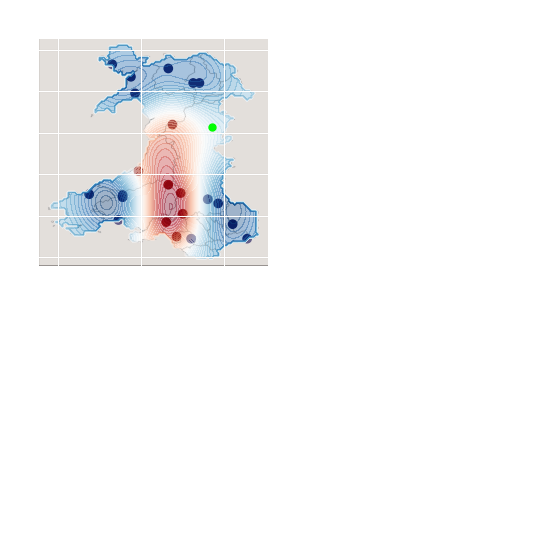

iteration  1
Accuracy is 0.500865218227264
iteration  2
Accuracy is 0.4785618150355701
iteration  3
Accuracy is 0.46318015766198806
iteration  4
Accuracy is 0.5425879638531051
iteration  5
Accuracy is 0.5287444722168814
iteration  6
Accuracy is 0.5473947317823495
iteration  7
Accuracy is 0.7758123437800423
iteration  8
Accuracy is 0.8177273601230532
iteration  9
Accuracy is 0.8169582772543742
iteration  10
Accuracy is 0.8365698904056912
iteration  11
Accuracy is 0.8006152662949433
iteration  12
Accuracy is 0.8023457027494713
iteration  13
Accuracy is 0.7985002884060758
iteration  14
Accuracy is 0.8046529513555085
iteration  15
Accuracy is 0.8096519900019227
iteration  16
Accuracy is 0.805998846375697
iteration  17
Accuracy is 0.8096519900019227
iteration  18
Accuracy is 0.831570851759277
iteration  19
Accuracy is 0.831570851759277
iteration  20
Accuracy is 0.8286867910017305
iteration  21
Accuracy is 0.82907133243607
experiment:  17


<IPython.core.display.Javascript object>


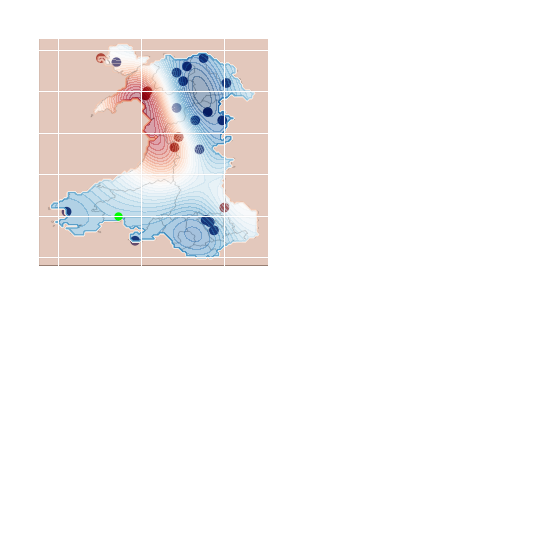

iteration  1
Accuracy is 0.49701980388386846
iteration  2
Accuracy is 0.588925206691021
iteration  3
Accuracy is 0.5912324552970583
iteration  4
Accuracy is 0.5968083060949817
iteration  5
Accuracy is 0.6018073447413959
iteration  6
Accuracy is 0.6018073447413959
iteration  7
Accuracy is 0.602576427610075
iteration  8
Accuracy is 0.5652759084791387
iteration  9
Accuracy is 0.6150740242261103
iteration  10
Accuracy is 0.6150740242261103
iteration  11
Accuracy is 0.6004614497212074
iteration  12
Accuracy is 0.6004614497212074
iteration  13
Accuracy is 0.6071909248221495
iteration  14
Accuracy is 0.6175735435493175
iteration  15
Accuracy is 0.6175735435493175
iteration  16
Accuracy is 0.6175735435493175
iteration  17
Accuracy is 0.6175735435493175
iteration  18
Accuracy is 0.6860219188617573
iteration  19
Accuracy is 0.6937127475485484
iteration  20
Accuracy is 0.690636416073832
iteration  21
Accuracy is 0.6904441453566622
experiment:  18


<IPython.core.display.Javascript object>


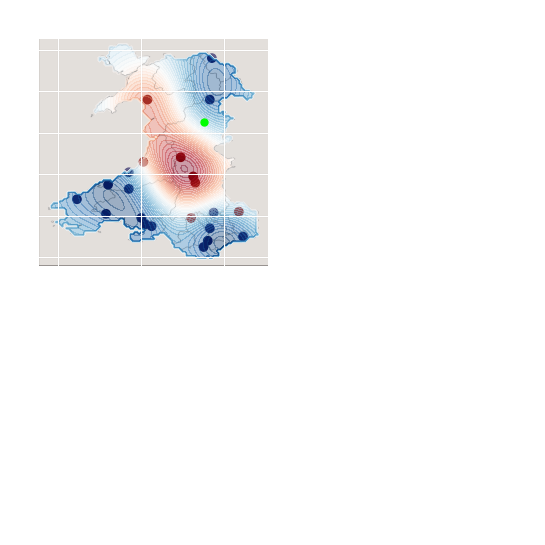

iteration  1
Accuracy is 0.39030955585464333
iteration  2
Accuracy is 0.6958277254374159
iteration  3
Accuracy is 0.6467986925591233
iteration  4
Accuracy is 0.6439146318015766
iteration  5
Accuracy is 0.7254374158815612
iteration  6
Accuracy is 0.7575466256489136
iteration  7
Accuracy is 0.7575466256489136
iteration  8
Accuracy is 0.756393001345895
iteration  9
Accuracy is 0.736781388194578
iteration  10
Accuracy is 0.7404345318208037
iteration  11
Accuracy is 0.7404345318208037
iteration  12
Accuracy is 0.7644683714670256
iteration  13
Accuracy is 0.7775427802345702
iteration  14
Accuracy is 0.7748509901941935
iteration  15
Accuracy is 0.7773505095174005
iteration  16
Accuracy is 0.7838877139011728
iteration  17
Accuracy is 0.7804268409921169
iteration  18
Accuracy is 0.7823495481638146
iteration  19
Accuracy is 0.7823495481638146
iteration  20
Accuracy is 0.7779273216689099
iteration  21
Accuracy is 0.7829263603153239
experiment:  19


<IPython.core.display.Javascript object>


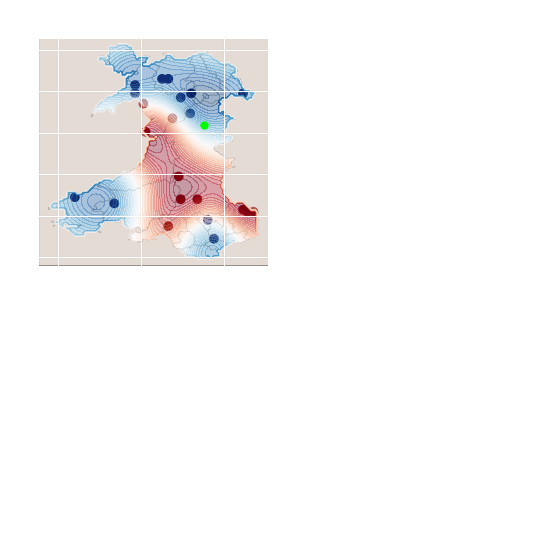

iteration  1
Accuracy is 0.5673908863680062
iteration  2
Accuracy is 0.6404537588925207
iteration  3
Accuracy is 0.6189194385695058
iteration  4
Accuracy is 0.8167660065372044
iteration  5
Accuracy is 0.8188809844260719
iteration  6
Accuracy is 0.7763891559315517
iteration  7
Accuracy is 0.833301288213805
iteration  8
Accuracy is 0.7956162276485291
iteration  9
Accuracy is 0.7958084983656989
iteration  10
Accuracy is 0.8261872716785233
iteration  11
Accuracy is 0.8231109402038069
iteration  12
Accuracy is 0.8246491059411651
iteration  13
Accuracy is 0.8371467025572006
iteration  14
Accuracy is 0.836762161122861
iteration  15
Accuracy is 0.836762161122861
iteration  16
Accuracy is 0.836762161122861
iteration  17
Accuracy is 0.8390694097288983
iteration  18
Accuracy is 0.8507979234762546
iteration  19
Accuracy is 0.8684868294558739
iteration  20
Accuracy is 0.8859834647183235
iteration  21
Accuracy is 0.8805998846375697
experiment:  20


<IPython.core.display.Javascript object>


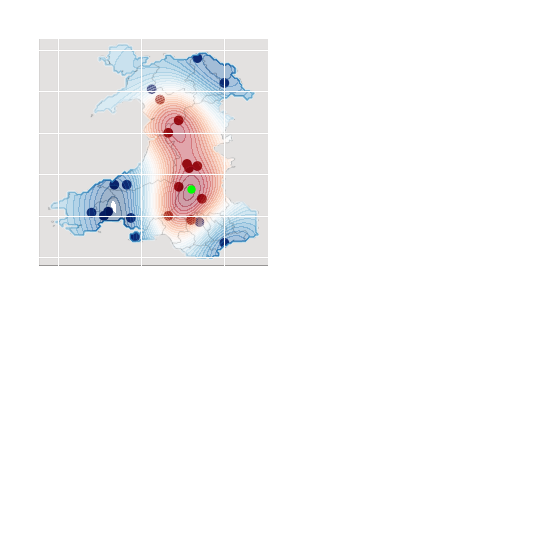

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.6762161122860988
iteration  3
Accuracy is 0.5174004999038646
iteration  4
Accuracy is 0.7194770236492982
iteration  5
Accuracy is 0.719669294366468
iteration  6
Accuracy is 0.7156316093059027
iteration  7
Accuracy is 0.6627571620842145
iteration  8
Accuracy is 0.7496635262449529
iteration  9
Accuracy is 0.7185156700634493
iteration  10
Accuracy is 0.7285137473562776
iteration  11
Accuracy is 0.7502403383964622
iteration  12
Accuracy is 0.7919630840223034
iteration  13
Accuracy is 0.802537973466641
iteration  14
Accuracy is 0.7954239569313594
iteration  15
Accuracy is 0.7727360123053258
iteration  16
Accuracy is 0.7892712939819265
iteration  17
Accuracy is 0.7892712939819265
iteration  18
Accuracy is 0.7892712939819265
iteration  19
Accuracy is 0.7892712939819265
iteration  20
Accuracy is 0.7892712939819265
iteration  21
Accuracy is 0.7873485868102288


In [11]:
from random import randint
import time

valid_seeds = [21,4,27,12,15,17,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [12]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 80.25 %
Improvement is = 23.71 %


In [13]:
np.savetxt('braninrandomrbf', Results)